# Variance Forecasts used in StrategyA

This file implies variance forecasts to back test a simple options trading strategy.
Data Frame Information: <br>

df_by_year[y] : Contains yearly option snapshots (trade book) (minute level index).
Xq_by_year[y][q] : Contains columns MFIV, bsIV and returns (Aligned).
outputs_byQ["X22_q1"] alike : Contain output variance per model and realized variance.





## Variables recap
* `YEARS`: list of years you iterate over (e.g., `[2022, 2023, 2024, 2025]`).
* `Xq_by_year`: dict mapping `year -> {"q1","q2","q3","q4"} -> quarter DataFrame` (must include columns `rt`, `bsIV`, `MFIV`).
* `quarters`: list of tuples `(qname, Xq)` where `qname="XYY_qk"` and `Xq=Xq_by_year[year][q]`.
* `qname`: quarter label string like `"X25_q1"`.
* `Xq`: the quarter DataFrame for `qname`.
* `idx_{qname}`: global int array of positional indices into `Xq.index` specifying the timestamps used for that quarter.
* `f_rollB_{qname}`: global float array of MS-GARCH base variance forecasts aligned to `t_idx` (same length/order as `idx_{qname}`).
* `idx_q`: `np.asarray(globals()[f"idx_{qname}"], int)`; the positional indices for the quarter in numpy form.
* `f_roll_q`: `np.asarray(globals()[f"f_rollB_{qname}"], float)`; the base forecast values in numpy form.
* `t_idx`: `Xq.index[idx_q]`; the timestamp index selected for modeling/evaluation.
* `df_use`: `Xq.loc[t_idx, ["rt","bsIV","MFIV"]]` filtered further to valid (non-NA/finite) rows.
* `h_base_s`: `pd.Series(f_roll_q, index=t_idx)`; base forecast series indexed by `t_idx`.
* `mask`: boolean filter keeping rows where `rt, bsIV, MFIV` are non-NA and `h_base_s` is finite.
* `h_base`: base forecast array after applying `mask` (same order as `df_use`).
* `rv`: realized variance proxy `rt^2` computed from `df_use["rt"]`.
* `SEQ_LEN`: integer lag/window length (here `5`) used to build LSTM sequences.
* `feats`: feature matrix of shape `(T, 2)` from `df_use[["bsIV","MFIV"]]`.
* `X_seq`: tensor of shape `(T-SEQ_LEN, SEQ_LEN, 2)` built from rolling windows of `feats`.
* `h_base2`: `h_base[SEQ_LEN:]`; base forecasts aligned to `X_seq`/targets after dropping first `SEQ_LEN`.
* `H`: forecast horizon in hours used to scale MFIV to horizon variance (here `5`).
* `dt_years`: `H / (365.25*24.0)`; horizon length expressed in years.
* `mfiv_H`: MFIV converted to horizon variance: `max(MFIV * dt_years, 1e-12)`.
* `scale`: scalar rescaling factor `median(h_base2) / median(mfiv_H[SEQ_LEN:])` to put MFIV on base-forecast scale.
* `h_iv2`: `max(mfiv_H[SEQ_LEN:] * scale, 1e-12)`; scaled MFIV horizon variance aligned to `X_seq`.
* `rv2`: `rv[SEQ_LEN:]`; realized variance targets aligned to `X_seq`.
* `lstm_corr`: trained `LSTMGatedIVCorrection` model fit on `(X_seq, rv2, h_base2, h_iv2)`.
* `g_hat`: model output array of log-multiplicative adjustments (same length as `rv2`).
* `h_final`: corrected variance forecast `h_base2 * exp(g_hat)` aligned to `rv2`.
* `h_final_byQ`: dict mapping `qname -> h_final` for each quarter.
* `g_hat_byQ`: dict mapping `qname -> g_hat` for each quarter.
* `w_byQ`: dict mapping `qname -> lstm_corr.last_w` (if available) for each quarter.
* `x_plot2`: `df_use.index[SEQ_LEN:]`; timestamps used for plotting/evaluating `rv2`, `h_base2`, `h_final`.
* `rv2_{qname}`: global storing `rv2` for quarter `qname`.
* `h_base2_{qname}`: global storing `h_base2` for quarter `qname`.
* `h_final_{qname}`: global storing `h_final` for quarter `qname`.
* `metrics`: function returning performance metrics given `(y_true, y_pred)` (here used for `rv2` vs forecasts).
* `tables_gatedIV`: dict mapping `qname ->` metrics table comparing `MS_base` vs `MS_gatedIV`.
* `results`: dict of metric outputs for `"MS_base"` and `"MS_gatedIV"` for a single quarter.
* `table`: `pd.DataFrame(results, index=["RMSE","MAE","NLL","QLIKE","Bias"]).T` rounded per quarter.


In [1]:
import sys
sys.path.insert(0, "/Users/shah/CODE_BOOK_3/code_document/MyRepo/THESIS")
sys.modules.pop("src", None)

In [2]:
import pandas as pd
import numpy as np
from math import sqrt, pi, exp
from arch import arch_model
import yfinance as yf 
from scipy.optimize import minimize
import warnings
from arch.__future__ import reindexing
from arch.utility.exceptions import ConvergenceWarning
from src.msGarch import msGARCH
from src.metrics import metrics
from src.msGarch import msGARCHIV
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="y is poorly scaled")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
# # DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

## MS-GARCH Base

### Regime 1: Symmetric GARCH with jumps (baseline)
$$
h_{t+1}^{(0)}=\omega_{0}+\alpha_{0}\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{0}h_t^{(0)}.
$$

### Regime 2: Asymmetric GJR-GARCH with jumps (leverage)
$$
h_{t+1}^{(1)}=\omega_{1}+\left(\alpha_{1}+\gamma_{1}\mathbf{1}_{\{u_t<0\}}\right)\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{1}h_t^{(1)}.
$$

### Regime 3: FIGARCH-style long-memory recursion with jumps
$$
h_{t+1}^{(2)}=\omega_{2}+\alpha_{2}\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{2}\left((1-d)\,h_t^{(2)}+d\,\bar{h}_t\right).
$$


## Data (1 min runtime)

In [4]:
# Hourly data
d_btc = pd.read_parquet("../../data/rawData/btc_underlying_minutely_2025.parquet")


In [5]:
# Options with minutely data 
df = pd.read_parquet("../../data/rawData/derivative_data_2025.parquet")

In [6]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../../data/rawData")
YEARS = [2022, 2023, 2024, 2025]

d_btc_raw_by_year = {}
df_raw_by_year = {}

for y in YEARS:
    d_btc_raw_by_year[y] = pd.read_parquet(DATA_DIR / f"btc_underlying_minutely_{y}.parquet")
    df_raw_by_year[y]    = pd.read_parquet(DATA_DIR / f"derivative_data_{y}.parquet")


In [7]:

from src.dataPrep import dataprep

d_btc_by_year = {}
df_by_year = {}

for y in YEARS:
    d_btc = d_btc_raw_by_year[y]
    df    = df_raw_by_year[y]

    prep = dataprep(d_btc=d_btc, df=df)
    d_btc_by_year[y], df_by_year[y] = prep.run_all()


In [8]:
df_by_year[2022]

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,...,combo_trade_id,combo_id,block_trade_id,liquidation,date_time,strike,type,option_price,maturity,rfr
date_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 22:59:20.379,285,238476733,1672613960379,3,0.0015,0.001243,44.87,BTC-13JAN23-19000-C,16597.37,buy,...,NaN,NaN,NaN,NaN,2023-01-01 22:59:20.379,19000.0,C,24.896055,2023-01-13,0.04260
2023-01-01 22:58:47.798,192,238476732,1672613927798,0,0.0020,0.002615,21.94,BTC-3JAN23-16750-C,16597.22,buy,...,NaN,NaN,NaN,NaN,2023-01-01 22:58:47.798,16750.0,C,33.194440,2023-01-03,0.04260
2023-01-01 22:57:34.244,155,238476728,1672613854244,3,0.0005,0.000517,24.85,BTC-2JAN23-16750-C,16597.22,buy,...,NaN,NaN,NaN,NaN,2023-01-01 22:57:34.244,16750.0,C,8.298610,2023-01-02,0.04260
2023-01-01 22:57:28.589,154,238476727,1672613848589,3,0.0005,0.000518,24.84,BTC-2JAN23-16750-C,16597.18,buy,...,NaN,NaN,NaN,NaN,2023-01-01 22:57:28.589,16750.0,C,8.298590,2023-01-02,0.04260
2023-01-01 22:55:21.237,491,238476687,1672613721237,2,0.0140,0.014040,34.40,BTC-13JAN23-17000-C,16593.56,sell,...,NaN,NaN,NaN,NaN,2023-01-01 22:55:21.237,17000.0,C,232.309840,2023-01-13,0.04260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:00:34.439,6,197390518,1640991634439,3,0.0475,0.047218,70.24,BTC-14JAN22-47000-C,46341.98,buy,...,NaN,NaN,NaN,NaN,2021-12-31 23:00:34.439,47000.0,C,2201.244050,2022-01-14,0.00033
2021-12-31 23:00:33.612,423,197390513,1640991633612,3,0.0090,0.008765,74.39,BTC-7JAN22-51000-C,46328.10,buy,...,NaN,NaN,NaN,NaN,2021-12-31 23:00:33.612,51000.0,C,416.952900,2022-01-07,0.00033
2021-12-31 23:00:33.550,422,197390512,1640991633550,3,0.0090,0.008765,74.39,BTC-7JAN22-51000-C,46328.10,buy,...,NaN,NaN,NaN,NaN,2021-12-31 23:00:33.550,51000.0,C,416.952900,2022-01-07,0.00033


## Load Data

In [12]:
# file_path = ("../data/d_X.parquet")
# X = pd.read_parquet(file_path)

import pandas as pd
from pathlib import Path

INDIR = Path("../../data/readyData")
YEARS = [2022, 2023, 2024, 2025]

X_by_year = {y: pd.read_parquet(INDIR / f"d_X_{y}.parquet") for y in YEARS}


In [13]:
# eps = 1e-12
# X[["bsIV","MFIV"]] = np.exp(
#     np.log(X[["bsIV","MFIV"]].clip(lower=eps))
#       .interpolate(method="time", limit_direction="both")
# )
# X

import numpy as np

eps = 1e-12
for y, X in X_by_year.items():
    X_by_year[y][["bsIV","MFIV"]] = np.exp(
        np.log(X[["bsIV","MFIV"]].clip(lower=eps))
          .interpolate(method="time", limit_direction="both")
    )


In [14]:
# # X must have a DatetimeIndex

# X25_q1 = X.loc["2025-01-01":"2025-03-31 23:59:59"]
# X25_q2 = X.loc["2025-04-01":"2025-06-30 23:59:59"]
# X25_q3 = X.loc["2025-07-01":"2025-09-30 23:59:59"]
# X25_q4 = X.loc["2025-10-01":"2025-12-31 23:59:59"]

Xq_by_year = {}

for y, X in X_by_year.items():
    Xq_by_year[y] = {
        "q1": X.loc[f"{y}-01-01":f"{y}-03-31 23:59:59"],
        "q2": X.loc[f"{y}-04-01":f"{y}-06-30 23:59:59"],
        "q3": X.loc[f"{y}-07-01":f"{y}-09-30 23:59:59"],
        "q4": X.loc[f"{y}-10-01":f"{y}-12-31 23:59:59"],
    }

# example: Xq_by_year[2025]["q1"]


In [15]:
Xq_by_year[2022]["q1"]

,rt,bsIV,MFIV
date_time,,,
2022-01-01 00:00:00+00:00,0.009782,3.834870,17.514097
2022-01-01 01:00:00+00:00,0.002855,3.834870,17.514097
2022-01-01 02:00:00+00:00,0.000406,3.834870,17.514097
2022-01-01 03:00:00+00:00,0.000085,3.834870,17.514097
2022-01-01 04:00:00+00:00,-0.002030,3.787864,30.529706
...,...,...,...
2022-03-31 19:00:00+00:00,-0.007949,1.013688,11.023218
2022-03-31 20:00:00+00:00,0.003567,0.001007,57.686731
2022-03-31 21:00:00+00:00,0.000371,0.000001,301.886347


In [16]:
Xq_by_year[2022]["q1"].columns

Index(['rt', 'bsIV', 'MFIV'], dtype='str')

In [17]:
# quarters = [X25_q1, X25_q2, X25_q3, X25_q4]
quarters = [Xq_by_year[y]["q1"], Xq_by_year[y]["q2"], Xq_by_year[y]["q3"], Xq_by_year[y]["q4"]]


In [18]:
from src.msGarch import msGARCH
from src.msGarch import msGARCHIV

## Load Saved MSGarch base Outputs

In [19]:
from src.LSTM_lib import LSTMGatedIVCorrection

In [20]:

#LOAD BASE 
import pickle
globals().update(pickle.load(open("../../outputs/ms_garch_outputs.pkl","rb")))


In [21]:
# import pickle
# d = pickle.load(open("../../outputs/ms_garch_outputs.pkl","rb"))
# [(k, getattr(v,"shape", len(v) if hasattr(v,"__len__") else None)) for k,v in d.items()]


### Base Model (3 Regime MS-GARCH) **vs** Base + gated IV correction


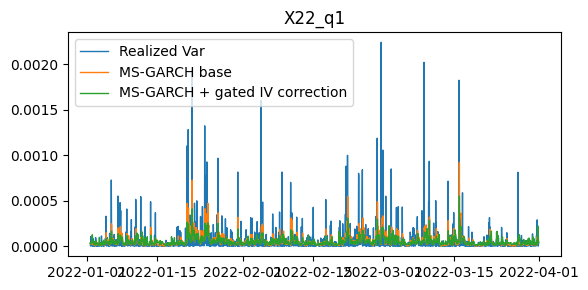

X22_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000156  0.000067 -3.388929 -8.615736 -0.000002
MS_gatedIV  0.000151  0.000062 -3.522130 -8.882136  0.000003


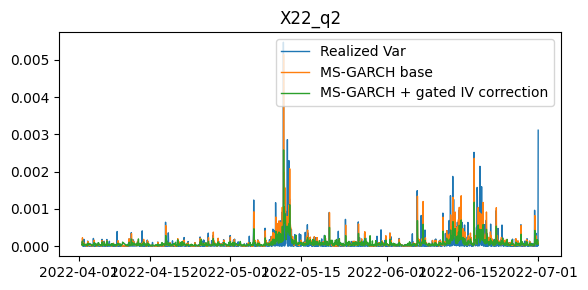

X22_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000254  0.000097 -3.364356 -8.566589 -0.000024
MS_gatedIV  0.000225  0.000083 -3.490568 -8.819013 -0.000003


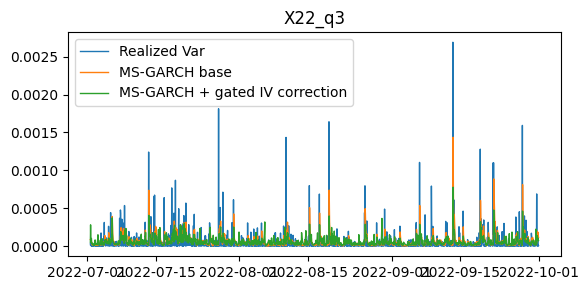

X22_q3
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000154  0.000067 -3.394236 -8.626350 -0.000017
MS_gatedIV  0.000141  0.000064 -3.598167 -9.034212 -0.000014


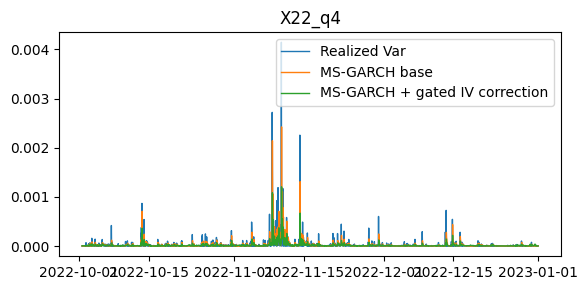

X22_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000154  0.000035 -1.938510 -5.714896 -0.000001
MS_gatedIV  0.000142  0.000029 -3.935007 -9.707892  0.000008


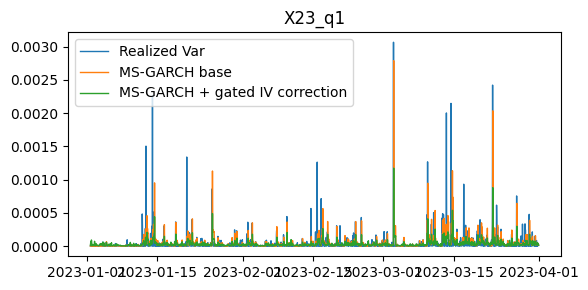

X23_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000176  0.000056 -3.442750 -8.723377 -0.000009
MS_gatedIV  0.000151  0.000044 -3.769623 -9.377123  0.000004


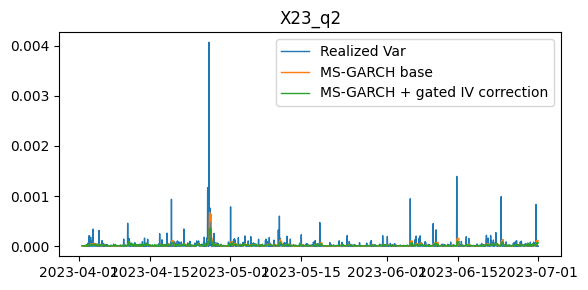

X23_q2
                RMSE       MAE       NLL    QLIKE      Bias
MS_base     0.000117  0.000028 -3.605166 -9.04821  0.000000
MS_gatedIV  0.000113  0.000025 -3.913362 -9.66460  0.000004


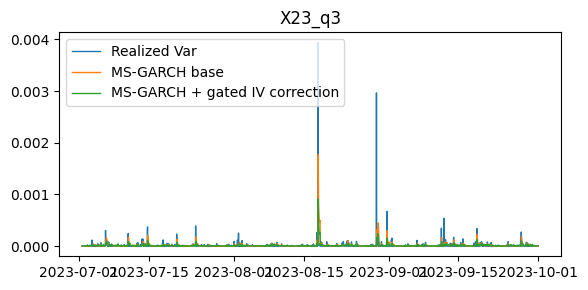

X23_q3
                RMSE       MAE       NLL      QLIKE      Bias
MS_base     0.000121  0.000021 -3.968440  -9.774757 -0.000004
MS_gatedIV  0.000113  0.000017 -4.287971 -10.413819  0.000000


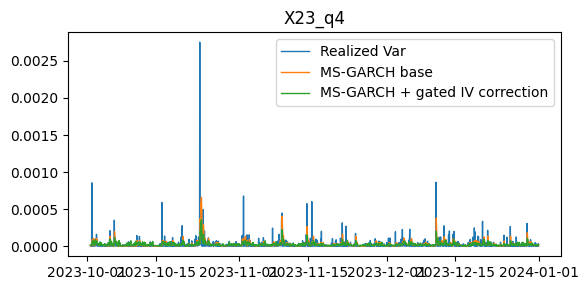

X23_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000085  0.000028 -3.805698 -9.449273 -0.000005
MS_gatedIV  0.000080  0.000025 -4.025321 -9.888519 -0.000002


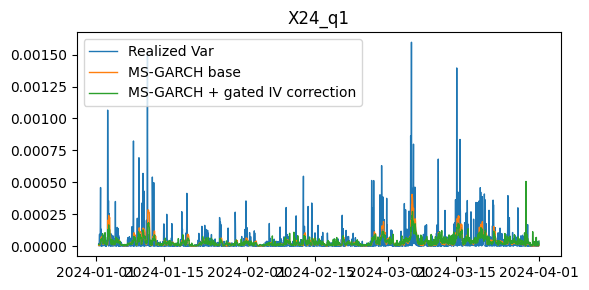

X24_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000100  0.000042 -3.638502 -9.114881  0.000003
MS_gatedIV  0.000099  0.000041 -3.798491 -9.434858  0.000005


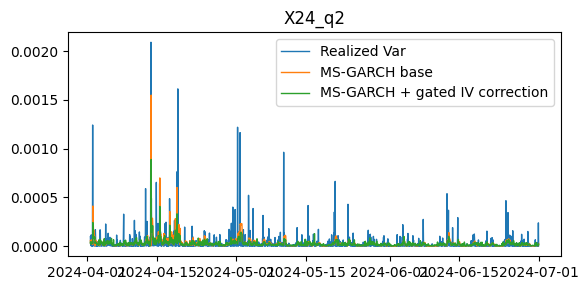

X24_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000099  0.000035 -3.698606 -9.235088  0.000000
MS_gatedIV  0.000094  0.000032 -3.946464 -9.730806  0.000003


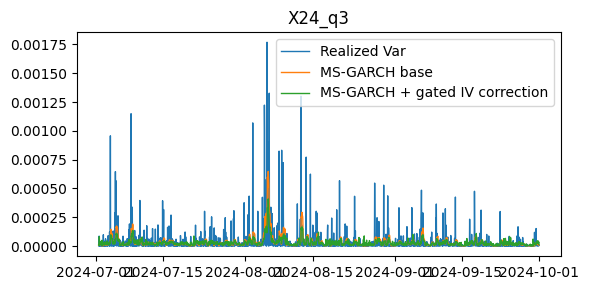

X24_q3
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000111  0.000043 -3.557385 -8.952646  0.000003
MS_gatedIV  0.000109  0.000040 -3.720326 -9.278528  0.000007


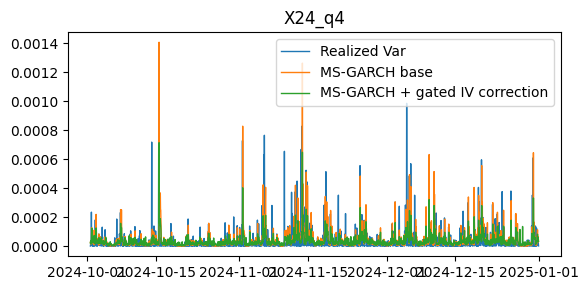

X24_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000104  0.000046 -3.592958 -9.023792 -0.000010
MS_gatedIV  0.000086  0.000039 -3.807973 -9.453824 -0.000002


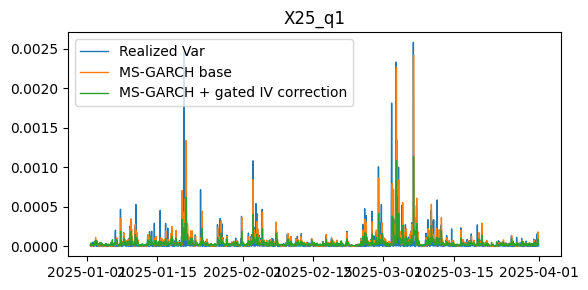

X25_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000160  0.000055 -3.673111 -9.184100 -0.000011
MS_gatedIV  0.000135  0.000043 -3.755520 -9.348916  0.000003


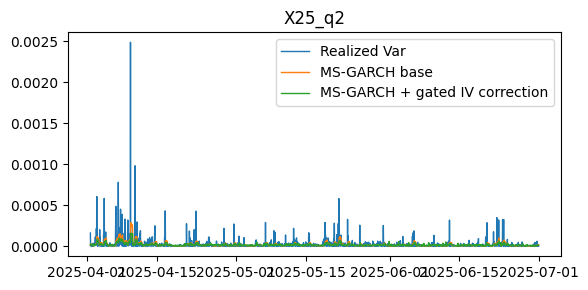

X25_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000077  0.000024 -3.913319 -9.664515  0.000002
MS_gatedIV  0.000076  0.000022 -4.008492 -9.854861  0.000005


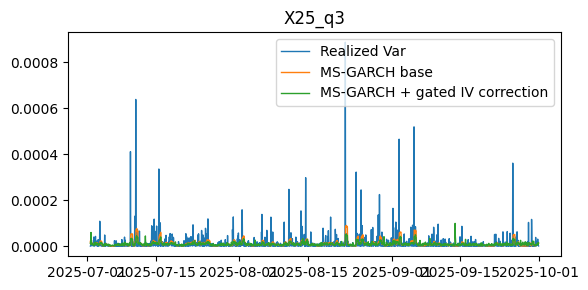

X25_q3
                RMSE       MAE       NLL      QLIKE      Bias
MS_base     0.000038  0.000013 -4.071487  -9.980852  0.000001
MS_gatedIV  0.000038  0.000012 -4.236778 -10.311433  0.000002


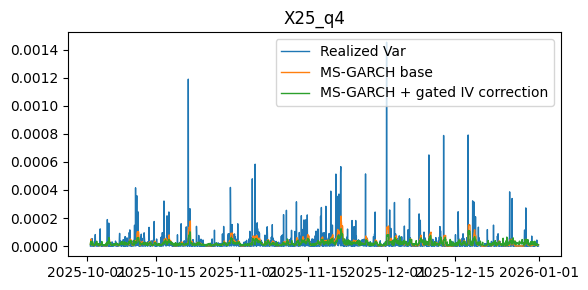

X25_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000074  0.000029 -3.594421 -9.026719  0.000003
MS_gatedIV  0.000072  0.000028 -3.830082 -9.498041  0.000005


In [22]:
# Requires : idx_{q}, f_rollB_{q}  (as globals)
# MS-GARCH base + LSTM (IV) correction per quarter
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

quarters = [(f"X{str(y)[-2:]}_{q}", Xq_by_year[y][q]) for y in YEARS for q in ["q1","q2","q3","q4"]]

h_final_byQ = {}
g_hat_byQ   = {}
w_byQ       = {}

tables_gatedIV = {}

for qname, Xq in quarters:

    idx_q    = np.asarray(globals()[f"idx_{qname}"], int)
    f_roll_q = np.asarray(globals()[f"f_rollB_{qname}"], float)

    t_idx  = Xq.index[idx_q]
    df_use = Xq.loc[t_idx, ["rt","bsIV","MFIV"]].copy()

    h_base_s = pd.Series(np.asarray(f_roll_q, float), index=t_idx)

    mask = df_use.notna().all(axis=1) & np.isfinite(h_base_s.values)
    df_use = df_use.loc[mask]
    h_base = h_base_s.loc[mask].to_numpy(float)

    rv = (df_use["rt"].to_numpy(float) ** 2)

    SEQ_LEN = 5
    feats = df_use[["bsIV","MFIV"]].to_numpy(np.float32)
    X_seq = []
    for i in range(SEQ_LEN, len(df_use)):
        X_seq.append(feats[i-SEQ_LEN:i])
    X_seq = torch.tensor(np.stack(X_seq))

    h_base2 = h_base[SEQ_LEN:]
    H = 5
    dt_years = H / (365.25 * 24.0)
    mfiv_H = np.maximum(df_use["MFIV"].to_numpy(float) * dt_years, 1e-12)

    scale = np.nanmedian(h_base2) / np.nanmedian(mfiv_H[SEQ_LEN:])
    h_iv2 = np.maximum(mfiv_H[SEQ_LEN:] * scale, 1e-12)

    rv2 = rv[SEQ_LEN:]
    lstm_corr = LSTMGatedIVCorrection(hidden_dim=32, lr=1e-3, epochs=30).fit_xy(X_seq, rv2, h_base2, h_iv2)

    g_hat = lstm_corr.predict(X_seq, h_base2, h_iv2).ravel()

    h_final = h_base2 * np.exp(g_hat)

    h_final_byQ[qname] = h_final
    g_hat_byQ[qname]   = g_hat
    w_byQ[qname]       = getattr(lstm_corr, "last_w", None)

    x_plot2 = df_use.index[SEQ_LEN:]
    rv2     = rv[SEQ_LEN:]

    globals()[f"rv2_{qname}"]     = rv2
    globals()[f"h_base2_{qname}"] = h_base2
    globals()[f"h_final_{qname}"] = h_final

    plt.figure(figsize=(6,3))
    plt.plot(x_plot2, rv2,     linewidth=1, label="Realized Var")
    plt.plot(x_plot2, h_base2, linewidth=1, label="MS-GARCH base")
    plt.plot(x_plot2, h_final, linewidth=1, label="MS-GARCH + gated IV correction")
    plt.title(qname); plt.legend(); plt.tight_layout(); plt.show()

    results = {}
    results["MS_base"]      = metrics(rv2, h_base2)
    results["MS_gatedIV"]   = metrics(rv2, h_final)

    table = pd.DataFrame(results, index=["RMSE","MAE","NLL","QLIKE","Bias"]).T.round(6)
    tables_gatedIV[qname] = table
    print(qname)
    print(table)


## StrategyA

### Strategy Execution Logic (Market-Based)

**Signal timing**
- Forecast is computed using data up to **t−1**
- Trade is executed at **t** (no look-ahead)

**Instrument traded**
- One BTC option per trade (per hour)
- Chosen as **nearest-to-ATM** and **nearest expiry** available at time *t*

**Entry**
- If signal = **+1**  **Buy option at ASK(t)**
- If signal = **−1**  **Sell option at BID(t)**

**Exit**
- Position is **closed at t+1**
- Long → **Sell at BID(t+1)**
- Short → **Buy back at ASK(t+1)**

**Expiry selection**
- At each trade time **t**, the option chosen is the one with the **nearest future maturity**
- Among options with the same maturity, the **closest-to-ATM strike** is selected

**Holding period**
- Exactly **1 hour**

**PnL**
- Long: `BID(t+1) − ASK(t)`
- Short: `ASK(t+1) − BID(t)`


In [23]:
# Create outputs_byQ dictionary of dataframes. Contains variance forecasts (from Base model,ms_gated_IV) and realized variance.
import pandas as pd

outputs_byQ = {q: pd.DataFrame({"rv": globals()[f"rv2_{q}"],
                           "ms_base": globals()[f"h_base2_{q}"],
                           "ms_gatedIV": globals()[f"h_final_{q}"]},
                          index=Xq_by_year[int("20"+q[1:3])][q[4:]].index[globals()[f"idx_{q}"]][5:]) 
          for q in [f"X{str(y)[-2:]}_{qq}" for y in YEARS for qq in ["q1","q2","q3","q4"]]}


In [24]:
outputs_byQ["X22_q1"].columns

Index(['rv', 'ms_base', 'ms_gatedIV'], dtype='str')

In [38]:
import numpy as np, pandas as pd

# ---------------- helpers ----------------

def qname_to_yq(qname):
    return int("20" + qname[1:3]), qname[4:]

def build_trade_frame(qname, Xq_by_year, outputs_byQ):
    y, q = qname_to_yq(qname)
    t_idx = Xq_by_year[y][q].index[globals()[f"idx_{qname}"]][5:]
    df = outputs_byQ[qname].copy()
    df.index = t_idx
    return df[["rv", "ms_base", "ms_gatedIV"]]

# ---------------- market prep ----------------

def resample_market_hourly(df_year):
    df = df_year.copy().sort_index()

    df["atm_dist"] = (df["strike"] - df["index_price"]).abs()

    hourly = (
        df.groupby(pd.Grouper(freq="1H"))
          .apply(lambda x: x.sort_values(["atm_dist", "maturity"]).iloc[0])
          .dropna()
    )

    # define bid / ask
    hourly["ask"] = np.where(hourly["direction"] == "buy",
                             hourly["option_price"],
                             np.nan)
    hourly["bid"] = np.where(hourly["direction"] == "sell",
                             hourly["option_price"],
                             np.nan)

    hourly["ask"] = hourly["ask"].ffill()
    hourly["bid"] = hourly["bid"].ffill()

    return hourly[["bid", "ask"]]

# ---------------- strategy ----------------

def strategyA_market(df_signal, market_hourly, forecast_col):
    # align
    mkt = market_hourly.loc[df_signal.index].dropna()

    f  = df_signal.loc[mkt.index, forecast_col].to_numpy()
    rv = df_signal.loc[mkt.index, "rv"].to_numpy()

    sig = np.sign(f - rv)
    # pos = np.r_[0, sig[:-1]]  # trade next hour
    pos = sig.copy() # trade at t since forecast is aligned to t-1.

    ask = mkt["ask"].to_numpy()
    bid = mkt["bid"].to_numpy()

    pnl = np.zeros(len(pos) - 1)

    for i in range(len(pnl)):
        if pos[i] == 1:       # long
            pnl[i] = bid[i+1] - ask[i]
        elif pos[i] == -1:    # short
            pnl[i] = ask[i+1] - bid[i]

    out = pd.DataFrame(index=mkt.index[1:])
    out["position"] = pos[:-1].astype(int)
    out["pnl"] = pnl
    out["cum_pnl"] = pnl.cumsum()

    sharpe = pnl.mean() / (pnl.std(ddof=1) + 1e-12)
    return out, sharpe

# ---------------- run all quarters ----------------

def run_strategyA_all(Xq_by_year, outputs_byQ, df_by_year, YEARS):
    qnames = [f"X{str(y)[-2:]}_{q}" for y in YEARS for q in ["q1","q2","q3","q4"]]
    res, rows = {}, []

    for qname in qnames:
        y, _ = qname_to_yq(qname)

        df_signal = build_trade_frame(qname, Xq_by_year, outputs_byQ)
        market_hr = resample_market_hourly(df_by_year[y])

        base_out, base_sh = strategyA_market(df_signal, market_hr, "ms_base")
        lstm_out, lstm_sh = strategyA_market(df_signal, market_hr, "ms_gatedIV")

        res[qname] = {"base": base_out, "lstm": lstm_out}
        rows.append((qname, base_sh, lstm_sh))

    sharpe_tbl = (
        pd.DataFrame(rows, columns=["qname", "sharpe_base", "sharpe_lstm"])
          .set_index("qname")
    )

    return res, sharpe_tbl


In [39]:
results_byQ["X23_q2"]["lstm"][["position", "cum_pnl"]]
sharpe_table


,sharpe_base,sharpe_lstm
qname,,
X22_q1,0.090772,0.102943
X22_q2,0.110554,0.097737
X22_q3,0.106606,0.134090
X22_q4,0.011255,-0.001770
X23_q1,0.043227,0.065370
X23_q2,0.054723,0.068135
X23_q3,0.010777,0.009332
X23_q4,0.082816,0.096017
X24_q1,0.059948,0.071468


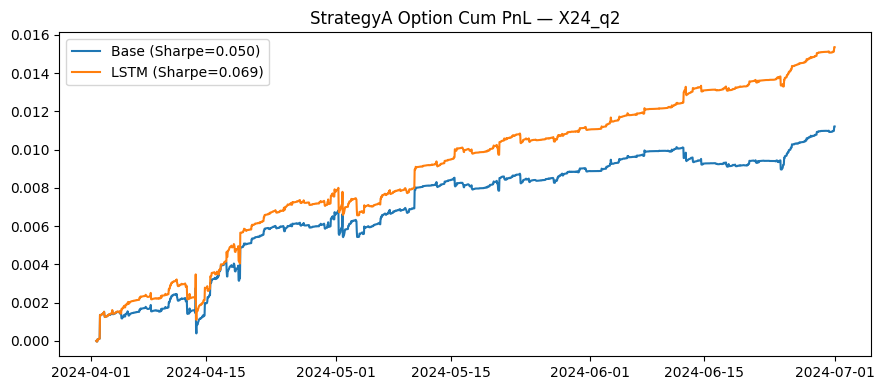

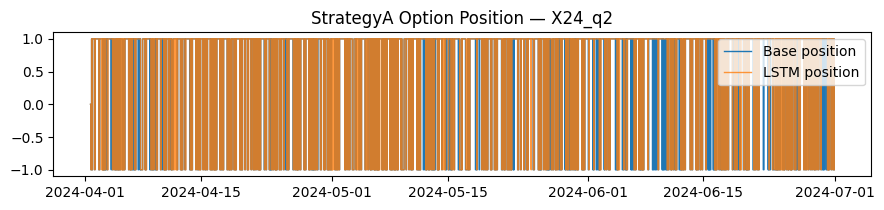

In [37]:
import matplotlib.pyplot as plt

q = "X24_q2"   # pick quarter

base = results_byQ[q]["base"]
lstm = results_byQ[q]["lstm"]

# ---- cumulative PnL ----
plt.figure(figsize=(9,4))
plt.plot(base.index, base["cum_pnl"],
         label=f"Base (Sharpe={sharpe_table.loc[q,'sharpe_base']:.3f})")
plt.plot(lstm.index, lstm["cum_pnl"],
         label=f"LSTM (Sharpe={sharpe_table.loc[q,'sharpe_lstm']:.3f})")
plt.title(f"StrategyA Option Cum PnL — {q}")
plt.legend()
plt.tight_layout()
plt.show()

# ---- positions ----
plt.figure(figsize=(9,2.2))
plt.step(base.index, base["position"], where="post",
         label="Base position", linewidth=1)
plt.step(lstm.index, lstm["position"], where="post",
         label="LSTM position", linewidth=1, alpha=0.8)
plt.title(f"StrategyA Option Position — {q}")
plt.legend()
plt.tight_layout()
plt.show()
